# Mulvariate regression

In this example we are using multivariate regression to determined the concentration of three different sugars : Fructose, Glucose and Sucrose in aqueous solution using FTIR. The samples were measured on a Diamond ATR. Spectra were recorded on different days by operators of varying capabilities.

Data is provided in the form of two csv files, one containing IR spectra and one containing concentrations. 




Required packages

- `matplotlib`
- `pandas`
- `scikit-learn`
- `numpy`
- `xarray`

In [10]:
import pandas as pd


import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

%matplotlib inline

## Multivariate models

First we load the spectral data:

In [11]:
spec_data = np.genfromtxt("sugar_spectra.csv", unpack=True)
wn = spec_data[0]
absorption = spec_data[1:]

For the sugar concentrations we use pandas. `index_col` makes pandas use the first column as index

In [12]:
concentrations = pd.read_csv("sugar concentration.csv",index_col=0)

In [13]:
concentrations

,Fructose,Sucrose,Glucose
0,2.0032,2.000,2.0000
1,2.0032,2.000,20.0000
2,20.0320,2.000,2.0000
3,2.0032,20.000,2.0000
4,20.0320,2.000,20.0000
5,20.0320,20.000,2.0000
6,2.0032,20.000,20.0000
7,20.0320,20.000,20.0000
8,2.0000,1.984,2.0140
9,2.0000,1.984,20.1400


And put the spectra into a DataArray with the same index as the concentrations:

In [14]:
sugar_da = xr.DataArray(absorption, 
                        dims=["idx", "wn"], # same order as numpy axes
                        coords={"wn":("wn", wn),
                                "idx":concentrations.index})
sugar_da

<xarray.DataArray (idx: 32, wn: 1712)>
array([[-2.10557191e-04,  1.67126083e-04,  7.35706650e-04, ...,
         9.88518586e-04,  1.24210073e-03,  2.31534039e-04],
       [-4.32274173e-05,  1.70591884e-05,  3.43002612e-05, ...,
        -3.40422353e-04,  1.10409269e-03,  1.62874092e-03],
       [ 1.43391034e-03,  1.40934193e-03,  1.31752132e-03, ...,
         1.61317724e-03,  1.50201318e-03, -5.36957057e-04],
       ...,
       [-1.51924061e-04, -1.70296276e-04, -1.28910206e-05, ...,
         1.40991330e-03,  1.01412693e-03,  1.20708195e-03],
       [-2.04554512e-04, -4.18788288e-04, -5.31320868e-04, ...,
         2.20293389e-03,  2.25328095e-03,  2.52244365e-03],
       [ 2.11384482e-04,  4.40155010e-04,  8.14707819e-05, ...,
         5.02631208e-03,  5.10346657e-03,  3.91386123e-03]])
Coordinates:
  * wn       (wn) float64 3.998e+03 3.996e+03 3.994e+03 ... 702.0 700.1 698.1
  * idx      (idx) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31

This is the full spectral dataset:

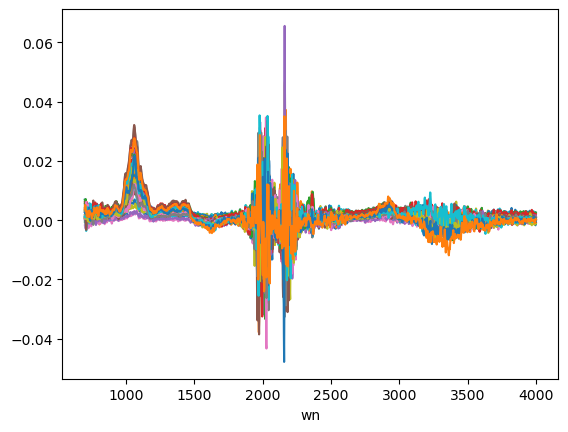

In [18]:
sugar_da.plot.line(x="wn", add_legend=False)
plt.show()

This is what the dataset looks like. Since this measurement was taken on a diamond ATR using water as background, there are several regions in the spectrum showing high noise. 

In this case the best part of the spectrum to use lies within the range of 850 cm^-1^  to 1500 cm^-1^. Use to `.sel` to restrict the spectral range accordingly and assign the result to the variable "sugar_reduced".

**Task**: Use the band assignment table provided with this exercise and your knowledge about the structure of carbohydrate and the sample to answer the following questions:

Q1: Which functional of carbohydrates are we likely measuring in this reduced spectral range.

Q2: What causes the high noise (=very little light reaches the detector) in the range between 3000 cm^-1^  to 3500 cm^-1^

In [16]:
plt.figure()
sugar_reduced = sugar_da.sortby("wn").sel(wn=slice(0,4000))
sugar_reduced.plot.line(x="wn", add_legend=False);

## PLS

The next steps follow almost identically to the code discussed in the exercise:

In [ ]:
from sklearn.cross_decomposition import PLSRegression
X = sugar_reduced.transpose("idx",...).sortby("idx")
y = concentrations

In [ ]:
from sklearn.cross_decomposition import PLSRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

In [ ]:
# instantiate
pls = PLSRegression(scale=False)

In [ ]:

gcv = GridSearchCV(pls, param_grid={"n_components":np.arange(1, 10)},
                   cv=LeaveOneOut(), scoring="neg_root_mean_squared_error")

gcv.fit(X, y)

res = pd.DataFrame(gcv.cv_results_)

plt.figure()
plt.plot(res.param_n_components, -res.mean_test_score)
plt.xlabel("latent variables")
plt.ylabel("RMSECV")


**Task**: Choose the number latent variables and then calibrate the PLSRegression. Explain your reasoning.


In [ ]:
pls = PLSRegression(n_components=4, scale=False)
pls.fit(X,y)


Finally, we use the model to predict carbohydrate concentrations. 

In [ ]:
prediction_arr = pls.predict(sugar_reduced.transpose("idx",...) )
prediction = pd.DataFrame(prediction_arr, 
                          columns=concentrations.columns, 
                          index=concentrations.index)
prediction

Below, we calculate the difference between predicted and actual values:

**Task**: Some of the predictions are likely better than others. 
Q3: Which predictions are especially far off?
Q4: Is there any trend for points that work especially well (or bad)? 

In [ ]:
(prediction - concentrations)

Above, we always use the keyword argument `scale=True` when instantiting `PLSRegression`. 

**Task**: Rerun the regressions with `scale=False` (the default). 
Q5: Does this improve or degrade the performance? Explain your thoughts on why this is?